In [ ]:
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt

import re
import collections

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/AI-3 Project/data/Preprocessed data/augmented_train_dataset.csv", index_col=0)
df_val = pd.read_csv("/content/drive/MyDrive/AI-3 Project/data/Preprocessed data/val_dataset.csv", index_col=0)
df_test = pd.read_csv("/content/drive/MyDrive/AI-3 Project/data/Preprocessed data/test_dataset.csv", index_col=0)

In [ ]:
len(df_train), len(df_val), len(df_test)

(14111, 273, 228)

In [ ]:
df_train["Sentences"] = "<s> "+df_train["Sentences"]+" </s>"
df_val["Sentences"] = "<s> "+df_val["Sentences"]+" </s>"
df_test["Sentences"] = "<s> "+df_test["Sentences"]+" </s>"

In [ ]:
df_train.head()

,Sentences,Label
0,<s> after receiving positive comments for some...,1
1,<s> i love how all the lynx space YMCA adverts...,0
2,<s> aye even here these dolts still see us as ...,1
3,<s> why are cold showers good for you </s>,0
4,<s> im a physicist and i worked on vacuum syst...,1


## ELMo Model

Peter et al. in [Deep contextualized Word Representations](https://arxiv.org/pdf/1802.05365v2.pdf) define 'Embeddings from Language Models', or **ELMo**, as a type of deep contextualized word representation that models both (1) complex characteristics of word use (e.g., syntax and semantics), and (2) how these uses vary across linguistic contexts (i.e., to model polysemy). Word vectors are learned functions of the internal states of a deep bidirectional language model (biLM), which is pre-trained on a large text corpus.

A biLM combines both a forward and backward LM. ELMo jointly maximizes the log likelihood of the forward and backward directions. 

We aim to train ELMo embeddings on our train dataset and do transfer learning to use it as layer in the final model which will predict whether a comment is sexist or not.

## Preprocessing for ELMo 

We use tensorflow tokeniser and fit it on the train dataset. We use this tokeniser to convert train, test and val data into tokens.

In [ ]:
vocab_size = 5000

tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=vocab_size, filters='!"#$%&()*+,-.:;=?@[\\]^_`{|}~\t\n',
    lower=True, split=' ', char_level=False, oov_token='UNK'
)

tokenizer.fit_on_texts(df_train["Sentences"])
train_data = tokenizer.texts_to_sequences(df_train["Sentences"])
reverse_dict = {j:i for i,j in tokenizer.word_index.items()}

We convert the validation and test datasets to their corresponding tokens based on the vocabulary we built.

In [ ]:
val_data = tokenizer.texts_to_sequences(df_val["Sentences"])
test_data = tokenizer.texts_to_sequences(df_test["Sentences"])

We read the glove gender neutral embeddings and convert each of the words in each comment to its corresponding embedding. We do cleaning to remove any words which are not present in the glove gender neutral embeddings.

In [ ]:
def read_glove_vecs(glove_file):
    with open(glove_file, encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
          if w in word_to_vec_map:
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [ ]:
embedding_path = '/content/drive/MyDrive/AI-3 Project/Embeddings/1b-vectors300-0.8-0.8.txt'
words_to_index, index_to_words, word_to_vec_map = read_glove_vecs(embedding_path)

In [ ]:
word_to_vec_map["<s>"] = np.random.randn(300)
word_to_vec_map["</s>"] = np.random.randn(300)

In [ ]:
def get_tokens_embedding_list(data, word_to_vec_map, reverse_dictionary):
  embedding_list = []
  tokens_list = []
  for sent_seq in data:
    tensor_list=[]
    token_temp = []
    for token in sent_seq:
      word = reverse_dictionary[token]
      if word in word_to_vec_map:
        tensor_list.append(word_to_vec_map[word])
        token_temp.append(token)
    embedding_list.append(tensor_list)
    tokens_list.append(token_temp)
  return tokens_list ,embedding_list

In [ ]:
X_train_tokens, X_train_embedding = get_tokens_embedding_list(train_data, word_to_vec_map, reverse_dict)
X_val_tokens, X_val_embedding = get_tokens_embedding_list(val_data, word_to_vec_map, reverse_dict)
X_test_tokens, X_test_embedding = get_tokens_embedding_list(test_data, word_to_vec_map, reverse_dict)

## Train ELMo Embeddings

We create the dataset to feed into the ELMo Model. We use a bidirectional LSTM with skip connections as our model. We will define a Toy ELMo Model to extract the embeddings from the layers and use that for tranfer learning.

In [ ]:
def transform_pad(input_tensor, input_target, input_N):
    # Transform the input for the f and b LSTM
    input_f  = input_tensor[:,:-1,:]
    input_b  = input_tensor[:,1:,:]
    
    # Transform the target for the f and b LSTM
    target_f  = input_target[:,1:]
    target_b  = input_target[:,:-1]
    
    # Pad the inputs
    input_f  = input_f.to_tensor(default_value=0, shape=[None, None, 300])
    input_b  = input_b.to_tensor(default_value=0, shape=[None, None, 300])
    
    # Pad the targets
    target_f = target_f.to_tensor(default_value=0, shape=[None, None])
    target_b = target_b.to_tensor(default_value=0, shape=[None, None])
    
    return (input_f, input_b, input_N), (target_f, target_b)

def create_dataset(data_in, target_in):
   
    N = [len(n) for n in data_in]
    
    ragged_input  = tf.ragged.constant(data_in, dtype=tf.float32)
    ragged_target = tf.ragged.constant(target_in, tf.int32)

    tensor_N = tf.constant(N, tf.int32)
    
    dataset = tf.data.Dataset.from_tensor_slices((ragged_input, ragged_target, tensor_N))
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(64)
    dataset = dataset.map(transform_pad,  num_parallel_calls=4)
                          
    dataset = dataset.prefetch(1)
    return dataset

In [ ]:
index = len(X_train_tokens)//2
dataset_train_1 = create_dataset(X_train_embedding[:index], X_train_tokens[:index])
dataset_train_2 = create_dataset(X_train_embedding[index:], X_train_tokens[index:])
dataset_train = dataset_train_1.concatenate(dataset_train_2)
dataset_val  = create_dataset(X_val_embedding, X_val_tokens)

In [ ]:
h_size = 150

tf.keras.backend.clear_session()

inputs_f = tf.keras.Input(shape=(None,300), dtype=tf.float32)
inputs_b = tf.keras.Input(shape=(None,300), dtype=tf.float32)
inputs_N = tf.keras.Input(shape=(), dtype=tf.int32)

masked_f = tf.keras.layers.Masking()(inputs_f)
masked_b = tf.keras.layers.Masking()(inputs_b)

RNN1_f = tf.keras.layers.LSTM(h_size, return_sequences=True, go_backwards=False)
h1_f = RNN1_f(masked_f)

proyection_Wf = tf.keras.layers.Dense(RNN1_f.units, name='Res_Wf', activation=None)
residual1_f = h1_f + proyection_Wf(masked_f)


RNN2_f = tf.keras.layers.LSTM(h_size, return_sequences=True, go_backwards=False)
h2_f = RNN2_f(residual1_f)

Dense = tf.keras.layers.Dense(vocab_size+1, activation='softmax')

pred_f = Dense(h2_f)

RNN1_b = tf.keras.layers.LSTM(h_size, return_sequences=True, go_backwards=True)
h1_b = RNN1_b(masked_b)

proyection_Wb = tf.keras.layers.Dense(RNN1_b.units, name='Res_Wb', activation=None)
residual1_b = h1_b + proyection_Wb(masked_b)

RNN2_b = tf.keras.layers.LSTM(h_size, return_sequences=True, go_backwards=True)
h2_b = RNN2_b(residual1_b)

pred_b = Dense(h2_b)

model = tf.keras.Model(inputs=(inputs_f, inputs_b, inputs_N), outputs = (pred_f, pred_b) )
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [ ]:
history = model.fit(dataset_train, epochs=10, validation_data=dataset_val)

Epoch 1/10
222/222 [==============================] - 59s 216ms/step - loss: 3.5638 - dense_loss: 1.7776 - dense_1_loss: 1.7862 - dense_accuracy: 0.8866 - dense_1_accuracy: 0.8871 - val_loss: 5.3292 - val_dense_loss: 2.6702 - val_dense_1_loss: 2.6591 - val_dense_accuracy: 0.5792 - val_dense_1_accuracy: 0.6115
Epoch 2/10
222/222 [==============================] - 46s 208ms/step - loss: 2.0517 - dense_loss: 1.0299 - dense_1_loss: 1.0218 - dense_accuracy: 0.8936 - dense_1_accuracy: 0.8963 - val_loss: 5.2492 - val_dense_loss: 2.6696 - val_dense_1_loss: 2.5796 - val_dense_accuracy: 0.5823 - val_dense_1_accuracy: 0.6093
Epoch 3/10
222/222 [==============================] - 47s 213ms/step - loss: 1.9464 - dense_loss: 0.9780 - dense_1_loss: 0.9684 - dense_accuracy: 0.8993 - dense_1_accuracy: 0.9032 - val_loss: 4.9692 - val_dense_loss: 2.5331 - val_dense_1_loss: 2.4362 - val_dense_accuracy: 0.6089 - val_dense_1_accuracy: 0.6382
Epoch 4/10
222/222 [==============================] - 47s 213ms/ste

In [ ]:
# For the output of Toy_Elmo, we have to extract the embeddings for each word.
# We have to remove the embeddings for <s> and </s>.
# And we have to invert the backwards LSTM embeddings.

# First we remove the </s> token from the backwards hidden states
mask1 = tf.sequence_mask(inputs_N-2, tf.shape(h1_b)[1]) 
mask2 = tf.math.logical_not(tf.sequence_mask(inputs_N -1,tf.shape(h1_b)[1])) 
mask = tf.math.logical_or(mask1, mask2)

# We invert the backwards embeddings
h1_b = h1_b[:,::-1,:]
h2_b = h2_b[:,::-1,:]
h1_b_m = tf.reshape(h1_b[mask],(tf.shape(h1_b)[0], tf.shape(h1_b)[1]-1, h_size) )
h2_b_m = tf.reshape(h2_b[mask],(tf.shape(h2_b)[0], tf.shape(h2_b)[1]-1, h_size) )


# Concatenate the embeddings
# Note that we skip the first element in the forward embeddings
# since the first token contains the hidden state of the <s>
h1 = tf.keras.layers.Concatenate(axis=2)([h1_f[:,1:,:], h1_b_m])
h2 = tf.keras.layers.Concatenate(axis=2)([h2_f[:,1:,:], h2_b_m])

# We extract the w2v embeddings from the forward input
# removing the first element corresponding to the <s> token.
w2v_emb = masked_f[:,1:,:]

Toy_ELMo = tf.keras.Model(inputs=(inputs_f, inputs_b, inputs_N), outputs = (w2v_emb, h1, h2) )

In [ ]:
for i in dataset_train:
    result = Toy_ELMo(i[0])
    break

In [ ]:
result[0].shape, result[1].shape, result[2].shape

(TensorShape([64, 866, 300]),
 TensorShape([64, 866, 300]),
 TensorShape([64, 866, 300]))

## Transfer Learning:

We use the train and validation dataset and convert it into a dataset object which can be used further for training the model. We define a Sauce layer to learn the embeddings for elmo from our dataset. The model will predict whether the comment is sexist or not.

In [ ]:
def transform_pad(input_tensor, input_N, class_target):
    input_f  = input_tensor[:,:-1,:]
    input_b  = input_tensor[:,1:,:]
    
    input_f  = input_f.to_tensor(default_value=0, shape=[None, None, 300])
    input_b  = input_b.to_tensor(default_value=0, shape=[None, None, 300])
    
    return (input_f, input_b, input_N), class_target

def create_dataset(data_in, target_in):
   
    N = [len(n) for n in data_in]
    ragged_input  = tf.ragged.constant(data_in, dtype=tf.float32)
    class_target = tf.ragged.constant(target_in, tf.int32)
    tensor_N = tf.constant(N, tf.int32)

    dataset = tf.data.Dataset.from_tensor_slices((ragged_input, tensor_N, class_target))
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(128)
    dataset = dataset.map(transform_pad, num_parallel_calls=4)
    dataset = dataset.prefetch(1)
    return dataset

In [ ]:
sexism_train = create_dataset(X_train_embedding, df_train["Label"])
sexism_val = create_dataset(X_val_embedding, df_val["Label"])
sexism_test = create_dataset(X_test_embedding, df_test["Label"])

In [ ]:
class ScaleLayer(tf.keras.layers.Layer):
    def __init__(self, shape):
        super(ScaleLayer, self).__init__()
        self.supports_masking = True
        self.shape = shape

    def build(self, input_shape):
        self.scale = tf.Variable(tf.nn.softmax([0.4,0.3,0.3]), trainable=True)
    def call(self, inputs):
        scale_norm = tf.nn.softmax(self.scale)
        return tf.tensordot(scale_norm, inputs, axes=1)

In [ ]:
tf.keras.backend.clear_session()
Toy_ELMo.trainable=False
# Define the inputs
inputs_f = tf.keras.Input(shape=(None,300), dtype=tf.float32)
inputs_b = tf.keras.Input(shape=(None,300), dtype=tf.float32)
inputs_N = tf.keras.Input(shape=(), dtype=tf.int32)

# Get the embeddings
e0,e1,e2 = Toy_ELMo((inputs_f, inputs_b, inputs_N))

# Make the sauce
Sauce_layer = ScaleLayer(3)
sauce = Sauce_layer(tf.stack([e0,e1,e2]))

# Define the masking
masked_sauce = tf.keras.layers.Masking()(sauce)

# Define the forward LSTM
RNN1_f = tf.keras.layers.LSTM(300, return_sequences=True, go_backwards=False)
h1_f = RNN1_f(masked_sauce)

RNN2_f = tf.keras.layers.LSTM(300, return_sequences=False, go_backwards=False)
h2_f = RNN2_f(h1_f)

pred = tf.keras.layers.Dense(2, activation='softmax')(h2_f)

model3 = tf.keras.Model(inputs=(inputs_f, inputs_b, inputs_N), outputs=pred)
model3.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics='accuracy')

In [ ]:
history3 = model3.fit(sexism_train, epochs=20, validation_data=sexism_val)

Epoch 1/20
111/111 [==============================] - 45s 293ms/step - loss: 0.6566 - accuracy: 0.6208 - val_loss: 0.7591 - val_accuracy: 0.4469
Epoch 2/20
111/111 [==============================] - 29s 262ms/step - loss: 0.6121 - accuracy: 0.6756 - val_loss: 0.7678 - val_accuracy: 0.4762
Epoch 3/20
111/111 [==============================] - 30s 271ms/step - loss: 0.6005 - accuracy: 0.6817 - val_loss: 0.8506 - val_accuracy: 0.4579
Epoch 4/20
111/111 [==============================] - 30s 268ms/step - loss: 0.5929 - accuracy: 0.6907 - val_loss: 0.8265 - val_accuracy: 0.4762
Epoch 5/20
111/111 [==============================] - 30s 268ms/step - loss: 0.5840 - accuracy: 0.6904 - val_loss: 0.7508 - val_accuracy: 0.4835
Epoch 6/20
111/111 [==============================] - 31s 273ms/step - loss: 0.5755 - accuracy: 0.6981 - val_loss: 0.7756 - val_accuracy: 0.4945
Epoch 7/20
111/111 [==============================] - 30s 271ms/step - loss: 0.5649 - accuracy: 0.7046 - val_loss: 0.8271 - val_ac

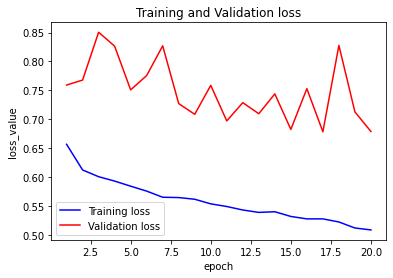

In [ ]:
train_loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs = range(1,len(train_loss)+1)

plt.figure()
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label ='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('epoch')
plt.ylabel('loss_value')
plt.legend()
plt.show()

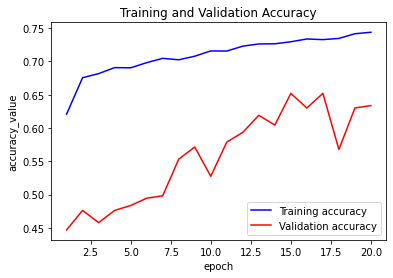

In [ ]:
train_acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

epochs = range(1,len(train_acc)+1)

plt.figure()
plt.plot(epochs, train_acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label ='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy_value')
plt.legend()
plt.show()

In [ ]:
result = model3.evaluate(sexism_test)
dict(zip(model3.metrics_names, result))

2/2 [==============================] - 0s 20ms/step - loss: 0.7032 - accuracy: 0.6360


{'accuracy': 0.6359649300575256, 'loss': 0.7032281756401062}

# Future Work

We have currently collected our data from multiple sources and done data augmentation. The training and validation set consist of examples from all sources whereas the test set consists of examples only from Sexist Workplace Statements [dataset](https://https://www.kaggle.com/dgrosz/sexist-workplace-statements/code). The goal was to train on different sources and see how it would perform for this targetted dataset. While the current dataset has produced good results with various models, the dataset can grow to capture more phrase structures and keywords. In many scenarios, the words are purposely misspelt or various slangs are used which need to be captured. The same word may be written in different spellings, with * etc. All of these should be mapped to the same word. 

Sexist comments in the Indian setting present a unique challenge with usage of words from various regional languages written in English. These often go undetected. Models would have to be built to specifically deal with such cases of code-switching.

# Experiments

We experiment with different model architectures based on various papers we read related to Hate Speech Detection. 

1. LSTM with no-pretrained embedding: Pitsilis et al. in "D[etecting offensive language in tweets using deep learning.](https://arxiv.org/abs/1801.04433)" talk about how the words used in sexist comments are not always captured by Glove or Word2Vec embeddings (as these are trained on Wikipedia or Google news data. They argue that for better performance, we should use a Embedding layer which will be learnt during training. The model consists of two LSTMs stacked together. We implemented the model for our dataset however, we achieved sub-par performance compared to using Glove embeddings. The main reason for this could be due to the difference in the datasets. Our dataset consists of Reddit, Twitter comments in proper English (making it more likely that these words will be present in the Glove Embedding file) whereas their dataset consists of Hinglish, Bangla words etc as well.

2. LSTM with Attention Layer: We experiment with a bi-directional LSTM model with an attention layer. However, the performance is poorer than of the bi-directional model without attention. A plausible reasoning could be that this occurs as most of our sentences are short in length as they are taken from Twitter. 


Link to notebook with the experiments: 
